# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


# Restart the kernel now before you proceed

In [2]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install --user tensorflow



Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [4]:
from sklearn.datasets import load_files       
from keras.utils import to_categorical
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob

# Define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = data['filenames']
    dog_targets = to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [5]:
# Load train, test, and validation datasets

train_files, train_targets = load_dataset('dogImages\\dogImages\\train')
valid_files, valid_targets = load_dataset('dogImages\\dogImages\\valid')
test_files, test_targets = load_dataset('dogImages\\dogImages\\test')

In [6]:
train_files

array(['dogImages\\dogImages\\train\\095.Kuvasz\\Kuvasz_06442.jpg',
       'dogImages\\dogImages\\train\\057.Dalmatian\\Dalmatian_04054.jpg',
       'dogImages\\dogImages\\train\\088.Irish_water_spaniel\\Irish_water_spaniel_06014.jpg',
       ...,
       'dogImages\\dogImages\\train\\029.Border_collie\\Border_collie_02069.jpg',
       'dogImages\\dogImages\\train\\046.Cavalier_king_charles_spaniel\\Cavalier_king_charles_spaniel_03261.jpg',
       'dogImages\\dogImages\\train\\048.Chihuahua\\Chihuahua_03416.jpg'],
      dtype='<U109')

In [7]:
# Load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages\\dogImages\\train\\*\\"))]


In [8]:
# Print statistics about the dataset
print(f'There are {len(dog_names)} total dog categories.')
print(f'There are {len(train_files) + len(valid_files) + len(test_files)} total dog images.')
print(f'There are {len(train_files)} training dog images.')
print(f'There are {len(valid_files)} validation dog images.')
print(f'There are {len(test_files)} test dog images.')

There are 133 total dog categories.
There are 8351 total dog images.
There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [9]:
import random
random.seed(8675309)

# Load filenames in shuffled human dataset
human_files = np.array(glob("lfw/lfw/*/*"))
random.shuffle(human_files)

# Print statistics about the human dataset
print(f'There are {len(human_files)} total human images.')

There are 13233 total human images.


In [10]:
import cv2 
img = cv2.imread(human_files[5])
human_files[3]

'lfw/lfw\\Laurence_Fishburne\\Laurence_Fishburne_0001.jpg'

In [11]:
# Ensure the full path is correct (include the filename and extension)
image_path = 'lfw\\lfw\\Peter_Gabriel\\Peter_Gabriel_0001.jpg'  # Update with actual filename
img = cv2.imread(image_path)

# Check if the image is loaded successfully
if img is None:
    print("Failed to load image. Check the file path:", image_path)
else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [12]:
import cv2
import matplotlib.pyplot as plt

# Extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# Load the color (BGR) image
img = cv2.imread(human_files[3])

# Check if the image was successfully loaded
if img is None:
    print(f"Failed to load image: {human_files[3]}")
else:
    # Convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find faces in the image
    faces = face_cascade.detectMultiScale(gray)

    # Print number of faces detected
    print('Number of faces detected:', len(faces))

    # Get bounding box for each detected face
    for (x, y, w, h) in faces:
        # Draw bounding box on the original image
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Convert the BGR image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


Number of faces detected: 1


<Figure size 640x480 with 1 Axes>

In [13]:
from PIL import Image
import numpy as np
import cv2

image_path = "lfw/lfw/Peter_Gabriel/Peter_Gabriel_0001.jpg"  # Make sure the path and extension are correct

# Open the image using PIL
img_pil = Image.open(image_path)

# Convert the PIL image to a NumPy array
img = np.array(img_pil)

# Convert RGB to BGR (OpenCV uses BGR, not RGB)
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Now you can continue using OpenCV with this image
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Find faces in the image
faces = face_cascade.detectMultiScale(gray)

# Print number of faces detected
print('Number of faces detected:', len(faces))



Number of faces detected: 1


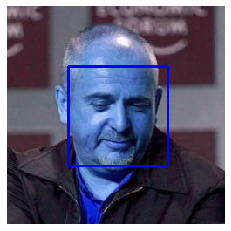

In [14]:
from PIL import Image, ImageOps
import cv2
import numpy as np

# Open image with PIL
image_path = "lfw/lfw/Peter_Gabriel/Peter_Gabriel_0001.jpg"
img_pil = Image.open(image_path)

# Convert PIL image to grayscale (using ImageOps)
gray_pil = ImageOps.grayscale(img_pil)

# Convert grayscale PIL image to NumPy array for OpenCV processing
gray = np.array(gray_pil)

# Load OpenCV's pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# Detect faces
faces = face_cascade.detectMultiScale(gray)

# Draw rectangles around detected faces
img_opencv = np.array(img_pil)  # Convert PIL image back to NumPy for OpenCV

for (x, y, w, h) in faces:
    cv2.rectangle(img_opencv, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Convert image back to RGB for matplotlib display
img_rgb = cv2.cvtColor(img_opencv, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
import matplotlib.pyplot as plt
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


Image path: lfw/lfw/Taoufik_Mathlouthi/Taoufik_Mathlouthi_0001.jpg
Number of faces detected: 1


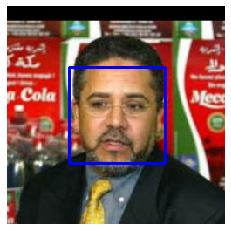

In [15]:
import cv2
import matplotlib.pyplot as plt
import os

# Extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# Ensure the image path is correct
image_path = "lfw/lfw/Taoufik_Mathlouthi/Taoufik_Mathlouthi_0001.jpg"  # Replace with correct path or confirm path is correct
print("Image path:", image_path)

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Error: The file {image_path} does not exist!")
else:
    # Load the color (BGR) image
    img = cv2.imread(image_path)

    # Check if the image loaded correctly
    if img is None:
        print(f"Failed to load image: {image_path}")
    else:
        # Convert BGR image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find faces in image
        faces = face_cascade.detectMultiScale(gray)

        # Print number of faces detected in the image
        print('Number of faces detected:', len(faces))

        # Get bounding box for each detected face
        for (x, y, w, h) in faces:
            # Add bounding box to color image
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image with bounding boxes
        plt.imshow(cv_rgb)
        plt.axis('off')  # Turn off axis
        plt.show()


Found 13233 images.
Using image: lfw/lfw\Aaron_Guiel\Aaron_Guiel_0001.jpg
Image loaded successfully!
Number of faces detected: 1


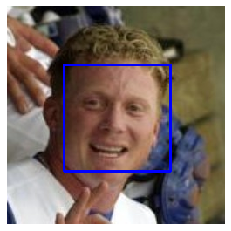

In [16]:
import cv2
import os
import matplotlib.pyplot as plt

# Ensure human_files contains only valid image files
human_files = []
folder_path = "lfw/lfw"  # Update this to your correct folder path

# Collect only image files (JPG, PNG, etc.)
for root, _, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):  # Ensure it's an image
            human_files.append(os.path.join(root, file))  # Add full path

# Check if we found any images
if not human_files:
    print("Error: No image files found in the directory!")
else:
    print(f"Found {len(human_files)} images.")

# Select an image (first valid one)
image_path = human_files[1] if len(human_files) > 1 else human_files[0]  # Use second image if possible
print("Using image:", image_path)

# Load the pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# Load the image
img = cv2.imread(image_path)

# Ensure the image was loaded correctly
if img is None:
    print("Failed to load image:", image_path)
else:
    print("Image loaded successfully!")

    # Convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find faces in the image
    faces = face_cascade.detectMultiScale(gray)

    # Print number of faces detected
    print('Number of faces detected:', len(faces))

    # Draw bounding boxes around detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Convert BGR image to RGB for matplotlib
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(cv_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


# EDA

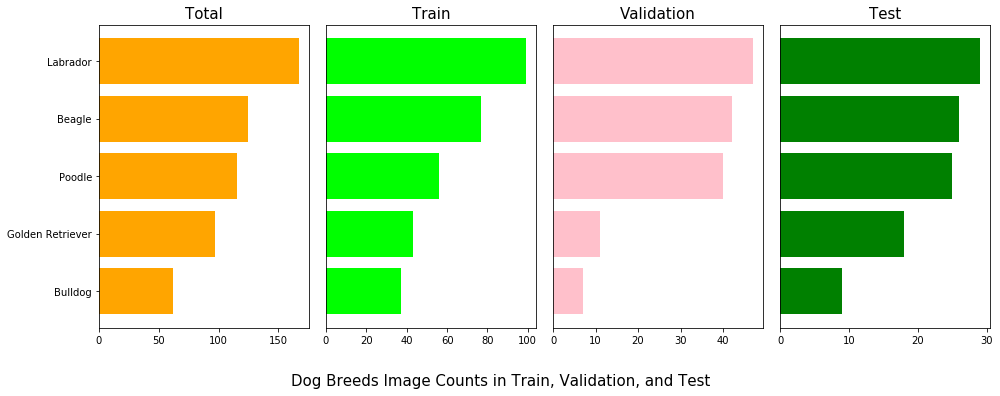

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample Dog Breeds
dog_names = ["Labrador", "Beagle", "Bulldog", "Poodle", "Golden Retriever"]

# Generate Sample Data (Random Counts)
train_targets = np.random.randint(10, 100, size=(1, len(dog_names)))
valid_targets = np.random.randint(5, 50, size=(1, len(dog_names)))
test_targets = np.random.randint(5, 30, size=(1, len(dog_names)))

# Convert to DataFrame
train_df = pd.DataFrame(train_targets, columns=dog_names)
valid_df = pd.DataFrame(valid_targets, columns=dog_names)
test_df = pd.DataFrame(test_targets, columns=dog_names)

# Total counts across all sets
total_df = (train_df.sum() + valid_df.sum() + test_df.sum()).sort_values()

# Function to plot distribution
def plot_distribution(df, ax, title, color, x_ticks=True):
    values = df.sort_values()
    ax.barh(range(len(values)), values, align='center', color=color, ecolor='black')
    ax.set_yticks(range(len(values)))
    ax.set_title(title, fontsize=15)
    if x_ticks:
        ax.set_yticklabels(values.index)
    else:
        ax.set_yticks([])

# Plot the data
fig, axes = plt.subplots(1, 4, figsize=(14, 5))

fig.subplots_adjust(top=0.85)


plot_distribution(total_df, axes[0], "Total", 'orange')
plot_distribution(train_df.sum(), axes[1], "Train", 'lime', x_ticks=False)
plot_distribution(valid_df.sum(), axes[2], "Validation", 'pink', x_ticks=False)
plot_distribution(test_df.sum(), axes[3], "Test", 'green', x_ticks=False)
fig.suptitle('Dog Breeds Image Counts in Train, Validation, and Test', fontsize=15, y=-0.05)
plt.tight_layout()
plt.show()


Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [17]:
# returns "True" if face is detected in image stored at img_path
#face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0



In [18]:
face_detector('images/Curly-coated_retriever_03896.jpg')#dog

False

In [19]:
face_detector('images/sample_human_output.png') #human

True

In [20]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

is_human_human = [face_detector(img) for img in human_files_short]
perc_human_human = 100 * np.mean(is_human_human)
print("{:.0f}% of the first 100 images in human_files have a detected human face"
          .format(perc_human_human))

is_dog_human = [face_detector(img) for img in dog_files_short]
perc_dog_human = 100 * np.mean(is_dog_human)
print("{:.0f}% of the first 100 images in dog_files have a detected human face"
          .format(perc_dog_human))

96% of the first 100 images in human_files have a detected human face
12% of the first 100 images in dog_files have a detected human face


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [21]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [22]:
#from keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications import ResNet50# type: ignore

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import numpy as np

def path_to_tensor(img_input):
    try:
        # Check if input is a file path (string)
        if isinstance(img_input, str):
            img = load_img(img_input, target_size=(224, 224))  # Corrected
        elif isinstance(img_input, np.ndarray):
            img = img_to_array(img_input)  # Corrected
        else:
            raise ValueError("Input must be a file path or a NumPy array.")

        x = img_to_array(img)  # Corrected
        x = np.expand_dims(x, axis=0)  # Add a batch dimension
        return x

    except Exception as e:
        print(f"Error: {e}")
        return None
    

def paths_to_tensor(img_paths):
    batch_tensors = []
    for img_path in img_paths:
        tensor = path_to_tensor(img_path)
        if tensor is not None:
            batch_tensors.append(tensor[0])
    return np.array(batch_tensors)


In [24]:
path_to_tensor('images/Curly-coated_retriever_03896.jpg')

array([[[[152., 154., 149.],
         [163., 166., 159.],
         [161., 165., 151.],
         ...,
         [113., 123., 132.],
         [108., 137., 169.],
         [ 72., 118., 170.]],

        [[167., 168., 160.],
         [174., 176., 165.],
         [171., 173., 160.],
         ...,
         [150., 155., 161.],
         [122., 142., 169.],
         [ 75., 108., 153.]],

        [[186., 187., 173.],
         [185., 186., 172.],
         [182., 183., 169.],
         ...,
         [204., 204., 204.],
         [160., 169., 184.],
         [ 93., 110., 138.]],

        ...,

        [[ 28.,  30.,  45.],
         [ 28.,  29.,  49.],
         [ 45.,  46.,  67.],
         ...,
         [ 92., 151.,  87.],
         [ 67., 123.,  62.],
         [ 22.,  75.,  21.]],

        [[ 31.,  32.,  50.],
         [ 36.,  37.,  58.],
         [ 41.,  42.,  63.],
         ...,
         [ 64., 122.,  63.],
         [ 84., 139.,  84.],
         [ 76., 125.,  80.]],

        [[ 27.,  28.,  48.],
       

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [25]:
#from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#from tensorflow.keras.models import ResNet50
from tensorflow.keras.preprocessing import image

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [26]:
ResNet50_predict_labels('images/American_water_spaniel_00648.jpg')

1/1 [==============================] - 1s 1s/step


221

In [27]:
ResNet50_predict_labels('lfw/lfw/Nancy_Pelosi/Nancy_Pelosi_0008.jpg')

1/1 [==============================] - 0s 142ms/step


490

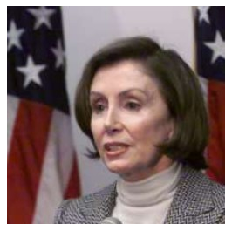

In [28]:
def display_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example Usage
display_image('lfw/lfw/Nancy_Pelosi/Nancy_Pelosi_0008.jpg')  # Ensure it's a proper dog image!


### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [29]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 



In [30]:
dog_detector('images/Curly-coated_retriever_03896.jpg')

1/1 [==============================] - 0s 149ms/step


True

In [31]:
dog_detector('images/Curly-coated_retriever_03896.jpg')

1/1 [==============================] - 0s 157ms/step


True

In [32]:
dog_detector('images/American_water_spaniel_00648.jpg')

1/1 [==============================] - 0s 129ms/step


True

In [33]:
dog_detector('lfw/lfw/Nancy_Pelosi/Nancy_Pelosi_0008.jpg')#Human

1/1 [==============================] - 0s 149ms/step


False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [34]:

is_human_like_dog = [dog_detector(img) for img in human_files_short]#checking huma
perc_human_human = 100 * np.mean(is_human_like_dog)
print("{:.0f}% of the first 100 images in human_files have a detected dog"
          .format(perc_human_human))

is_dog = [dog_detector(img) for img in dog_files_short]#checking dog
perc_dog_human = 100 * np.mean(is_dog)
print("{:.0f}% of the first 100 images in dog_files have a detected dog"
          .format(perc_dog_human))


1/1 [==============================] - 0s 125ms/step
0% of the first 100 images in human_files have a detected dog
1/1 [==============================] - 0s 125ms/step
100% of the first 100 images in dog_files have a detected dog


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [35]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  

def image_generator(files, targets, batch_size):
    while True:
        batch_paths = np.random.choice(a=files, size=batch_size)
        batch_input = paths_to_tensor(batch_paths)
        valid_paths = [p for p in batch_paths if path_to_tensor(p) is not None]
        batch_indices = [np.where(files == img_path)[0][0] for img_path in valid_paths]
        batch_output = np.array([targets[index] for index in batch_indices])

        if len(batch_input) > 0:  # making sure that there is data to to be shown
            yield batch_input, batch_output

# Create generators for train, validation, and test datasets
train_generator = image_generator(train_files, train_targets, batch_size=64)
valid_generator = image_generator(valid_files, valid_targets, batch_size=64)
test_generator = image_generator(test_files, test_targets, batch_size=64)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [36]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO:Architecture definistion
model.add(Conv2D(input_shape = (224, 224, 3), filters = 16, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 64)       0

### Compile the Model

In [37]:
from keras.optimizers import Adam

# Set a smaller learning rate
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [38]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

# Add checkpoint to save the best model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',verbose=1, save_best_only=True)

# ReduceLROnPlateau: This callback reduces the learning rate as the metric stops improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Ensure at least 1 step per epoch
steps_per_epoch = max(1, len(train_files) // 32)
validation_steps = max(1, len(valid_files) // 32)

print(f"Training on {len(train_files)} images, {steps_per_epoch} steps per epoch")
print(f"Validating on {len(valid_files)} images, {validation_steps} validation steps")

# Train the model
history =model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[checkpointer, reduce_lr],
    verbose=2

)

Training on 6680 images, 208 steps per epoch
Validating on 835 images, 26 validation steps
Epoch 1/5

Epoch 1: val_loss improved from inf to 4.84991, saving model to saved_models\weights.best.from_scratch.hdf5
208/208 - 395s - loss: 6.5667 - accuracy: 0.0135 - val_loss: 4.8499 - val_accuracy: 0.0162 - lr: 0.0010 - 395s/epoch - 2s/step
Epoch 2/5

Epoch 2: val_loss improved from 4.84991 to 4.80469, saving model to saved_models\weights.best.from_scratch.hdf5
208/208 - 467s - loss: 4.7988 - accuracy: 0.0171 - val_loss: 4.8047 - val_accuracy: 0.0355 - lr: 0.0010 - 467s/epoch - 2s/step
Epoch 3/5

Epoch 3: val_loss improved from 4.80469 to 4.76713, saving model to saved_models\weights.best.from_scratch.hdf5
208/208 - 404s - loss: 4.7087 - accuracy: 0.0310 - val_loss: 4.7671 - val_accuracy: 0.0294 - lr: 0.0010 - 404s/epoch - 2s/step
Epoch 4/5

Epoch 4: val_loss improved from 4.76713 to 4.72627, saving model to saved_models\weights.best.from_scratch.hdf5
208/208 - 343s - loss: 4.6391 - accuracy

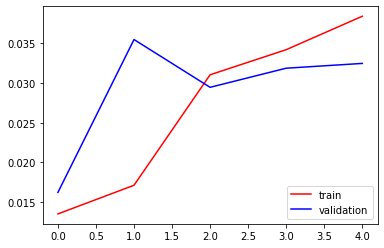

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()
     

### Load the Model with the Best Validation Loss

In [40]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [41]:
# Evaluate the model on the test data using `evaluate_generator`
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=len(test_files) // 32)

# Convert the accuracy to percentage
test_accuracy = test_accuracy * 100

print('Test accuracy: %.4f%%' % test_accuracy)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Test accuracy: 3.8462%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [42]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [43]:
train_VGG16.shape

(6680, 7, 7, 512)

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [44]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 133)               68229     
                                                                 
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [45]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [46]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True, save_format="h5")

#train_VGG16 = train_VGG16[:6675]

if train_VGG16.shape[0] > train_targets.shape[0]:
    train_VGG16 = train_VGG16[:train_targets.shape[0]]
elif train_targets.shape[0] > train_VGG16.shape[0]:
    train_targets = train_targets[:train_VGG16.shape[0]]
    
history=VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
329/334 [============================>.] - ETA: 0s - loss: 7.6970 - accuracy: 0.2278
Epoch 1: val_loss improved from inf to 3.59932, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 2s 5ms/step - loss: 7.6360 - accuracy: 0.2305 - val_loss: 3.5993 - val_accuracy: 0.4455
Epoch 2/20
330/334 [============================>.] - ETA: 0s - loss: 2.1722 - accuracy: 0.5982
Epoch 2: val_loss improved from 3.59932 to 2.46992, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 2.1634 - accuracy: 0.6000 - val_loss: 2.4699 - val_accuracy: 0.5820
Epoch 3/20
325/334 [============================>.] - ETA: 0s - loss: 1.2314 - accuracy: 0.7497
Epoch 3: val_loss improved from 2.46992 to 2.11061, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 1.2268 - accuracy: 0.7496 - val_loss: 2.1106 - val_accuracy: 0.6263
Epoch 4/

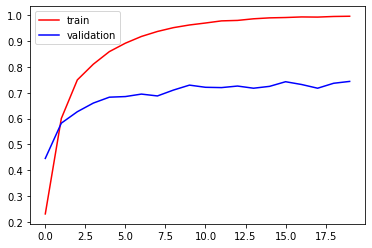

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()
     

### Load the Model with the Best Validation Loss

In [48]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [49]:
# Predict the test data
test_predictions = VGG16_model.predict(test_VGG16, batch_size=20)

# Check the lengths of predictions and targets
print(f"Number of test predictions: {len(test_predictions)}")
print(f"Number of test targets: {len(test_targets)}")

# Adjust if necessary
if len(test_predictions) > len(test_targets):
    test_predictions = test_predictions[:len(test_targets)]
elif len(test_targets) > len(test_predictions):
    test_targets = test_targets[:len(test_predictions)]

print(f"Number of test predictions after adjustment: {len(test_predictions)}")
print(f"Number of test targets after adjustment: {len(test_targets)}")

# Calculate test accuracy
test_accuracy = 100 * np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_targets, axis=1))
print('Test accuracy: %.4f%%' % test_accuracy)

42/42 [==============================] - 0s 2ms/step
Number of test predictions: 836
Number of test targets: 836
Number of test predictions after adjustment: 836
Number of test targets after adjustment: 836
Test accuracy: 72.4880%


### Predict Dog Breed with the Model

In [50]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [51]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [52]:

### TODO: Define your architecture.
Resnet50_model = Sequential()

Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation = 'softmax'))

Resnet50_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [53]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [54]:
from keras.callbacks import ModelCheckpoint

# Check the shapes of the training data and targets
print(f"train_Resnet50 shape: {train_Resnet50.shape}")
print(f"train_targets shape: {train_targets.shape}")

# If the shapes don't match, align them
if train_Resnet50.shape[0] != train_targets.shape[0]:
    min_samples = min(train_Resnet50.shape[0], train_targets.shape[0])
    train_Resnet50 = train_Resnet50[:min_samples]
    train_targets = train_targets[:min_samples]
    print(f"Aligned train_Resnet50 and train_targets to {min_samples} samples.")

# Check the shapes of the validation data and targets
print(f"valid_Resnet50 shape: {valid_Resnet50.shape}")
print(f"valid_targets shape: {valid_targets.shape}")

# If the shapes don't match, align them
if valid_Resnet50.shape[0] != valid_targets.shape[0]:
    min_samples = min(valid_Resnet50.shape[0], valid_targets.shape[0])
    valid_Resnet50 = valid_Resnet50[:min_samples]
    valid_targets = valid_targets[:min_samples]
    print(f"Aligned valid_Resnet50 and valid_targets to {min_samples} samples.")

# ModelCheckpoint callback to save best weights based on validation loss
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True, monitor='val_loss', mode='min')

# Compile the model (if not already compiled)
Resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=Resnet50_model.fit(train_Resnet50, train_targets, 
                   validation_data=(valid_Resnet50, valid_targets),
                   epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)


train_Resnet50 shape: (6680, 1, 1, 2048)
train_targets shape: (6680, 133)
valid_Resnet50 shape: (835, 1, 1, 2048)
valid_targets shape: (835, 133)
Epoch 1/20
330/334 [============================>.] - ETA: 0s - loss: 1.6660 - accuracy: 0.6055
Epoch 1: val_loss improved from inf to 0.85742, saving model to saved_models\weights.best.Resnet50.hdf5
334/334 [==============================] - 3s 6ms/step - loss: 1.6550 - accuracy: 0.6073 - val_loss: 0.8574 - val_accuracy: 0.7473
Epoch 2/20
334/334 [==============================] - ETA: 0s - loss: 0.3544 - accuracy: 0.9067
Epoch 2: val_loss improved from 0.85742 to 0.67446, saving model to saved_models\weights.best.Resnet50.hdf5
334/334 [==============================] - 2s 6ms/step - loss: 0.3544 - accuracy: 0.9067 - val_loss: 0.6745 - val_accuracy: 0.7689
Epoch 3/20
329/334 [============================>.] - ETA: 0s - loss: 0.1640 - accuracy: 0.9657
Epoch 3: val_loss improved from 0.67446 to 0.63212, saving model to saved_models\weights.bes

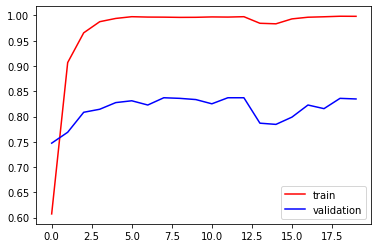

In [55]:

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()
     

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [56]:
### TODO: Load the model weights with the best validation loss.

Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [57]:
test_predictions = Resnet50_model.predict(test_Resnet50, batch_size=20)

# Check the lengths of predictions and targets
print(f"Number of test predictions: {len(test_predictions)}")
print(f"Number of test targets: {len(test_targets)}")

# Adjust if necessary
if len(test_predictions) > len(test_targets):
    test_predictions = test_predictions[:len(test_targets)]
elif len(test_targets) > len(test_predictions):
    test_targets = test_targets[:len(test_predictions)]

print(f"Number of test predictions after adjustment: {len(test_predictions)}")
print(f"Number of test targets after adjustment: {len(test_targets)}")

### TODO: Calculate classification accuracy on the test dataset.

test_accuracy = 100 * np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_targets, axis=1))
print('Test accuracy: %.4f%%' % test_accuracy)

42/42 [==============================] - 0s 2ms/step
Number of test predictions: 836
Number of test targets: 836
Number of test predictions after adjustment: 836
Number of test targets after adjustment: 836
Test accuracy: 81.4593%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

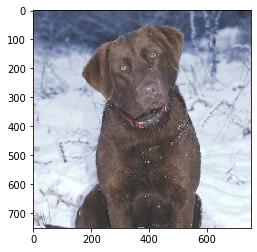

1/1 [==============================] - 0s 32ms/step
train\047.Chesapeake_bay_retriever


In [58]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50

def Resnet50_predict_breed(img_path):
    # Extract bottleneck features from the image
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    
    # Check if bottleneck features were extracted successfully
    if bottleneck_feature is None:
        return "Error in extracting bottleneck features"
    
    # Predict the breed by using the ResNet50 model
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    
    # Get the index of the predicted breed
    predicted_index = np.argmax(predicted_vector)
    
    # Return the predicted dog breed name
    return dog_names[predicted_index]

# Display the image and predict the breed
image_to_predict =  dog_files_short[-56]  # Assuming you have a list of dog image file paths
image = cv2.imread(image_to_predict)  # Read the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert color from BGR to RGB for displaying
plt.show()

# Call the prediction function and print the breed
predicted_breed = Resnet50_predict_breed(image_to_predict)
print(predicted_breed)


In [59]:
 extract_Resnet50(path_to_tensor('dogImages\\dogImages\\train\\095.Kuvasz\\Kuvasz_06442.jpg'))

1/1 [==============================] - 1s 1s/step


array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [3.2674308e+00, 3.5953641e-02, 0.0000000e+00, ...,
          1.6583951e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [1.4115635e+00, 2.5124013e-01, 0.0000000e+00, .

1/1 [==============================] - 0s 12ms/step
train\095.Kuvasz


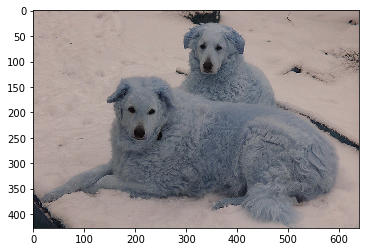

In [71]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def Resnet50_predict_breed(image_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(image_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]
  

# return results

image_to_predict = dog_files_short[0]
plt.imshow(cv2.imread(image_to_predict))
print(Resnet50_predict_breed(image_to_predict))

In [61]:
dog_files_short[0]

'dogImages\\dogImages\\train\\095.Kuvasz\\Kuvasz_06442.jpg'

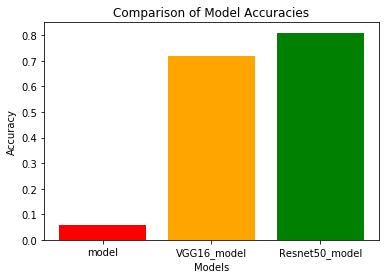

In [70]:
import matplotlib.pyplot as plt

models = ['model', 'VGG16_model', 'Resnet50_model']  # Replace with actual model names
accuracies = [0.06, 0.72, 0.81]  # Replace with actual accuracy values for each model

plt.bar(models, accuracies, color=['red', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()


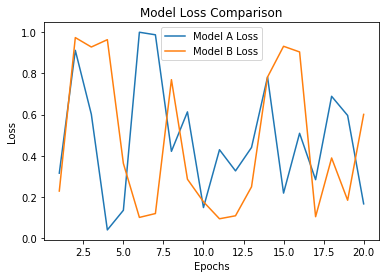

In [63]:
import numpy as np

epochs = np.arange(1, 21)  # Example for 20 epochs
model_a_loss = np.random.rand(20)  # Replace with actual loss values for Model A
model_b_loss = np.random.rand(20)  # Replace with actual loss values for Model B

plt.plot(epochs, model_a_loss, label='Model A Loss')
plt.plot(epochs, model_b_loss, label='Model B Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Comparison')
plt.show()


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

1/1 [==============================] - 1s 508ms/step


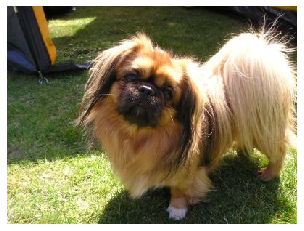

1/1 [==============================] - 0s 16ms/step
This is an image of a dog, a train\117.Pekingese to be specific.


In [64]:
import cv2
import matplotlib.pyplot as plt


### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

import cv2
import matplotlib.pyplot as plt

def imageClassifier(path):
    # Load the image
    img = cv2.imread(path)
    if img is None:
        print(f"Error: Unable to read {path}. File might be missing or corrupted.")
        return
    
    # Convert BGR to RGB for correct color display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect if the image contains a dog
    if dog_detector(path):
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()
        print(f"This is an image of a dog, a {Resnet50_predict_breed(path)} to be specific.")
    # Detect if the image contains a human
    elif face_detector(path):
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()
        print(f"This is an image of a human. If it were a dog, it would be a {Resnet50_predict_breed(path)}.")
    # If neither a dog nor a human is detected
    else:
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()
        print("Error: Unfortunately, the image is neither a human nor a dog. Please try with a different image.")

# Example usage
imageClassifier('dogImages\\dogImages\\train\\117.Pekingese\\Pekingese_07595.jpg')

1/1 [==============================] - 0s 94ms/step


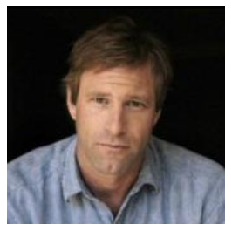

1/1 [==============================] - 0s 16ms/step
This is an image of a human. If it were a dog, it would be a train\127.Silky_terrier.


In [65]:
imageClassifier('lfw/lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [66]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

1/1 [==============================] - 0s 166ms/step


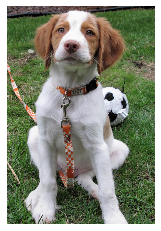

1/1 [==============================] - 0s 16ms/step
This is an image of a dog, a train\037.Brittany to be specific.


In [67]:
imageClassifier('images/Brittany_02625.jpg')

In [68]:
import os
import cv2
import matplotlib.pyplot as plt

def display_images_from_folder(folder_path):
    # List all files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Display each image
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(image_file)
        plt.axis('off')
        plt.show()

# Example usage
folder_path = 'lfw'
display_images_from_folder(folder_path)